# Create data

Let's create some synthetic data. This data has:

* 2 informative features (with 4 classes in circles)
* 4 uninformative and noisy features

In [20]:
from distributed import Client
client = Client()
client

/Users/scott/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:64484 Dashboard: http://127.0.0.1:64485/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [21]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_random_state

def get_data(n=60_000):
    X1, y1 = make_circles(n_samples=n // 2, random_state=0, noise=0.04)
    X2, y2 = make_circles(n_samples=n // 2, random_state=1, noise=0.04)
    X2[:, 0] += 0.6
    X_info = np.concatenate((X1, X2))
    y = np.concatenate((y1, y2 + 2))

    rng = check_random_state(42)
    random_feats = rng.uniform(-1, 1, size=(X_info.shape[0], 4))
    X = np.hstack((X_info, random_feats))
    return X, y

X, y = get_data()

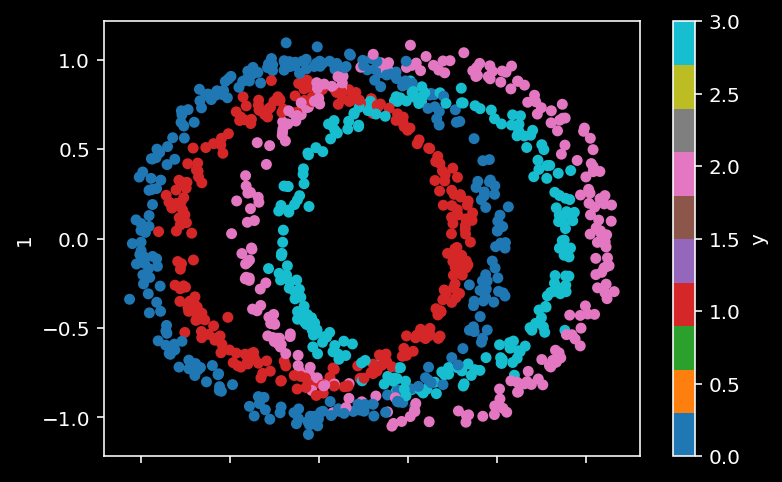

In [22]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

df = pd.DataFrame(X[:, :2])
df["y"] = y
ax = df.sample(1_000).plot.scatter(x=0, y=1, c="y", colormap="tab10")

# Model

This Scikit-learn's neural network.

In [23]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

# Data preprocessing

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 / 6, random_state=42)

In [25]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Parameters

*One* hyperparameter influences the model architecture, `hidden_layer_sizes`.

All other hyperparameters control getting to the optimal model of that architecture.

In [26]:
params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3)
    ],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [32, 64, 128, 256, 512],  # 5
}

# Setup

In [27]:
from dask_ml.model_selection import HyperbandSearchCV

# Hyperparameter optimization with Hyperband

## Parameters

The inputs to `HyperbandSearchCV` require knowing two items:

1. `n_examples`: number of examples that longest trained model sees
2. `n_params`: approximate number of hyperparameter combinations to sample

In [28]:
n_examples = 50 * len(X_train)
n_params = 27

In [29]:
max_iter = n_params
chunks = n_examples // n_params

max_iter, chunks

(27, 92592)

I tweak `n_params` a bit to get an evenly chunked Dask array:

Then, the inputs for Hyperband fall out pretty naturally:

In [30]:
import dask.array as da
X_train = da.from_array(X_train, chunks=chunks)
y_train = da.from_array(y_train, chunks=chunks)
y_train.chunks

((50000,),)

In [31]:
from dask_ml.model_selection import HyperbandSearchCV

search = HyperbandSearchCV(
    model,
    params,
    max_iter=max_iter,
    aggressiveness=4,
    verbose=True,
    random_state=42,
)

In [32]:
%%time
search.fit(X_train, y_train, classes=[0, 1, 2, 3])

[CV, bracket=2] train, test examples = 40000, 10000
[CV, bracket=2] creating 16 models
[CV, bracket=1] train, test examples = 40000, 10000
[CV, bracket=1] creating 6 models
[CV, bracket=0] train, test examples = 40000, 10000
[CV, bracket=0] creating 3 models
[CV, bracket=0] test/validation score of 0.35040 received after 1 partial_fit calls
[CV, bracket=1] test/validation score of 0.33710 received after 1 partial_fit calls
[CV, bracket=2] test/validation score of 0.40870 received after 1 partial_fit calls
[CV, bracket=1] test/validation score of 0.88300 received after 6 partial_fit calls
[CV, bracket=2] test/validation score of 0.89500 received after 4 partial_fit calls
[CV, bracket=1] test/validation score of 0.91960 received after 24 partial_fit calls
[CV, bracket=2] test/validation score of 0.91000 received after 16 partial_fit calls
[CV, bracket=0] test/validation score of 0.88780 received after 27 partial_fit calls
CPU times: user 10.6 s, sys: 1.32 s, total: 11.9 s
Wall time: 53 s

HyperbandSearchCV(aggressiveness=4,
         estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
         max_iter=27,
         parameters={'hidden_layer_sizes': [(24,), (12, 12), (6, 6, 6, 6), (4, 4, 4, 4, 4, 4), (12, 6, 3, 3)], 'alpha': array([1.00000e-06, 1.00694e-06, ..., 9.93109e-04, 1.00000e-03]), 'batch_size': [32, 64, 128, 256, 512]},
         patience=False, random_state=42, scoring=None, test_size=None,
         tol=0.001, verbose=True)

In [33]:
search.best_score_

0.9196

In [34]:
search.best_estimator_

MLPClassifier(activation='relu', alpha=6.9317172761554e-05, batch_size=128,
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 12), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [35]:
search.best_params_

{'hidden_layer_sizes': (12, 12),
 'batch_size': 128,
 'alpha': 6.9317172761554e-05}

In [17]:
search.metadata

{'partial_fit_calls': 175,
 'n_models': 25,
 'brackets': [{'bracket': 0,
   'n_models': 3,
   'partial_fit_calls': 81,
   'decisions': [27],
   'SuccessiveHalvingSearchCV params': {'aggressiveness': 4,
    'max_iter': 27,
    'n_initial_iter': 27,
    'n_initial_parameters': 3,
    'patience': False,
    'random_state': 42,
    'scoring': None,
    'test_size': None,
    'tol': 0.001,
    'verbose': (True, ', bracket=0')}},
  {'bracket': 1,
   'n_models': 6,
   'partial_fit_calls': 54,
   'decisions': [6, 24],
   'SuccessiveHalvingSearchCV params': {'aggressiveness': 4,
    'max_iter': 27,
    'n_initial_iter': 6,
    'n_initial_parameters': 6,
    'patience': False,
    'random_state': 1608637543,
    'scoring': None,
    'test_size': None,
    'tol': 0.001,
    'verbose': (True, ', bracket=1')}},
  {'bracket': 2,
   'n_models': 16,
   'partial_fit_calls': 40,
   'decisions': [1, 4, 16],
   'SuccessiveHalvingSearchCV params': {'aggressiveness': 4,
    'max_iter': 27,
    'n_initial_it

## Performance

Let's visualize the output of the best estimator.

So, let's

1. create a grid in the two informative dimensions
2. see what group label for each point

In [18]:
dim1 = np.linspace(-2, 2, num=200)
dim2 = np.linspace(-2, 2.00, num=200)
rng = check_random_state(42)
grid = [[x, y, *rng.uniform(-1, 1, size=4)] for x in dim1 for y in dim2]
X_show = np.array(grid)

y_show = search.best_estimator_.predict(X_show)

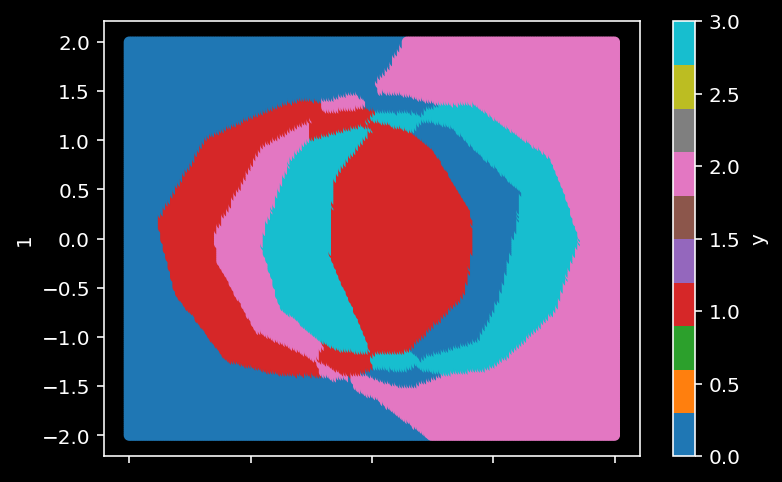

In [19]:
show = pd.DataFrame(X_show)
show["y"] = y_show


ax = show.plot.scatter(x=0, y=1, c="y", cmap="tab10")


## Example for the slides

The example tunes a more complicated search space.

It will use...

In [7]:
params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3)
    ],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [32, 64, 128, 256, 512],  # 5
    "learning_rate": ["constant", "invscaling"],  # 2
    "learning_rate_init": np.logspace(-4, -2, num=1000), # cnts
    "power_t": np.linspace(0.1, 0.9, num=1000), # cnts
    "momentum": np.linspace(0, 1, num=1000),  # cnts
    "random_state": list(range(10_000)),
}

In [11]:
n_examples = 50 * len(X_train)
n_params = 300 - 1